# CPSC 330 Lecture 10

#### Lecture plan

- 👋
- **Turn on recording**
- Announcements (5 min)
- Dataset of the week: regression! (20 min)
- Regression score functions: mean squared error and R^2 (10 min)
- Break (5 min)
- Linear regression intro (10 min)
- Exploring `alpha` (5 min)
- Error metrics revisited (15 min)
- Transforming the targets (10 min)

## Learning objectives

- Apply scikit-learn to regression problems using `Ridge`, etc.
- Appropriately select a scoring metric given a regression problem.
- Interpret and communicate the meanings of different scoring metrics on regression problems.
  - MSE, RMSE, $R^2$, MAPE
- Avoid sklearn's `LinearRegression` in the absence of further training
- Relate the `Ridge` hyperparameter `alpha` to the `LogisticRegression` hyperparameter `C` (they are opposites)
- log-transform the target values in a regression problem, either "manually" or with `TransformedTargetRegressor`.

In [2]:
from pandas_profiling import ProfileReport

In [3]:
plt.rcParams['font.size'] = 16

## Announcements

Homework assignments:

- hw4 deadline passed
- hw5 posted, due Monday at 11:59pm
- After that a 2-week break from hw 
- Next week we have the midterm on Thursday
- Will spend some time on midterm review in class on Tuesday
 
Midterm:

- Poll results: https://piazza.com/class/kb2e6nwu3uj23?cid=284
- Clearly there's no way to please everyone! 
- Zoom invigilation: 44% (very close to even). I prefer not to, so we'll go with **no**. Sorry to the 44%.
- Open book: 68% course materials only, 57% whole internet. Given that I have no way to enforce this, I think **whole internet** is more fair.
- Can't go back restriction: 11%. OK, I hear you on this one. I'm changing my original plan and going with **no** restriction.
- Randomly select students afterward: 35%. Ok, I'll go with **no** then. 
- Shuffled order: this was not on the poll, because I can't quite decide on this yet. It depends if the midterm has independent questions or a "story". TBA. 

## Data set of the week (20 min)

This week in lecture we will be focussing on the [Kaggle House Prices dataset](https://www.kaggle.com/c/home-data-for-ml-course/) with house prices from Ames, Iowa. As usual, to run this notebook you'll need to download the data. Unzip the data. Rename `train.csv` to `housing.csv` and move it into the data directory of this repo. (For this dataset, train and test have already been separated. The "test" data they provide is actually what we call deployment. They only provide the X, not the y. So we couldn't actually use Kaggle's test set as our test set, since we need the y values for that.)

In [4]:
df = pd.read_csv("data/housing.csv", index_col=0)

In [5]:
df_train, df_test = train_test_split(df, random_state=123)

In [6]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1447,20,RL,NaN,26142,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,157900
1124,20,RL,50.0,9405,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,118000
187,80,RL,NaN,9947,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,GdPrv,NaN,0,6,2009,WD,Normal,173000
1021,20,RL,60.0,7024,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,176000
68,20,RL,72.0,10665,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,226000


- Here, the target is `SalePrice`. Note that this is numeric, not categorical.
- In this case, we call the task **regression** (as opposed to classification).

In [7]:
df_train.shape

(1095, 80)

Above: this dataset has very few examples, but a lot of features.

In [8]:
# df_train.info()

#### Step 1: `pandas_profiler`

In [9]:
profile = ProfileReport(df_train, minimal=True)

In [10]:
profile.to_notebook_iframe();

#### Types of features

- How does pandas profiling figure out the data type?
- You can look at the Python data type and say floats are numeric, strings are categorical. 
  - However, in doing so you would miss out on various subtleties such as some of the string features being ordinal rather than truly categorical. 
  - Also, it will think free text is categorical. 

This is a good time to look at the `data_description.txt` provided with the dataset.


- There are a bunch of ordinal features using the same scale: excellent, good, average, etc.
  - These I'm calling `ordinal_features_reg`.
- There are a bunch more ordinal features using different scales.
  - These I'm calling `ordinal_features_oth`
  - To save time I'm ignoring the ordinality and just encoding them as categorical.

In [11]:
X_train = df_train.drop(columns=['SalePrice'])
y_train = df_train['SalePrice']

X_test = df_test.drop(columns=['SalePrice'])
y_test = df_test['SalePrice']

In [12]:
numeric_features     = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
                        'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                        'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 
                        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                        'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']
ordinal_features_reg = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ordinal_features_oth = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'Functional',  'Fence']
categorical_features = list(set(X_train.columns) - set(numeric_features) - set(ordinal_features_reg))

#all_features = numeric_features + ordinal_features_reg + categorical_features + ordinal_features_oth

ordering = ['Po', 'Fa', 'TA', 'Gd', 'Ex'] # if N/A it will just impute something, per below

A couple questions to ponder:

- We can make our own features too. Would price per square foot be a good feature to add in here?
- Are `MoSold` and `YrSold` reasonable features to use?

#### Step 2: build Pipelines for each feature type

We'll use the `make_pipeline` syntax in sklearn, which doesn't require us to specify a name each time.

In [13]:
numeric_preprocessing = make_pipeline(SimpleImputer(strategy='median'), 
                                      StandardScaler())

In [14]:
ordinal_preprocessing = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                                      OrdinalEncoder(categories=[ordering]*len(ordinal_features_reg)))

In [15]:
categorical_preprocessing = make_pipeline(SimpleImputer(strategy='constant', fill_value="?"),
                                          OneHotEncoder(handle_unknown='ignore', sparse=False))

- We'll just use `SimpleImputer` again.
  - In reality we'd want to go through this more carefully.
  - We may also want to drop some columns that are almost entirely missing.
  - We could also check for outliers, and do other exploratory data analysis (EDA).
- Also, note how `make_pipeline` gives each step a default name:

In [16]:
ordinal_preprocessing;

Now we'll build the `ColumnTransformer`:

In [17]:
preprocessing = ColumnTransformer([
    ('numeric', numeric_preprocessing, numeric_features),
    ('ordinal', ordinal_preprocessing, ordinal_features_reg),
    ('categorical', categorical_preprocessing, categorical_features)
])

In the hw4 question I accidentally deleted, I asked you to try this out on your training data,
just to see if you could get the columns lined up:

In [18]:
preprocessing.fit(X_train);

In [19]:
ohe_columns = list(preprocessing.named_transformers_['categorical'].named_steps['onehotencoder'].get_feature_names(categorical_features))
new_columns = numeric_features + ordinal_features_reg + ohe_columns

In [20]:
X_train_enc = pd.DataFrame(preprocessing.transform(X_train), index=X_train.index, columns=new_columns)

In [21]:
X_train_enc.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,MoSold_9,MoSold_10,MoSold_11,MoSold_12,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1447,-0.046315,1.654400,-0.775646,1.255836,-0.282035,-1.105566,0.491436,0.327430,-0.28498,0.064219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1124,-0.888437,-0.093394,-0.775646,3.019968,-0.773017,1.117128,-0.569906,-0.942714,-0.28498,0.297501,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
187,-0.046315,-0.036795,0.647021,-0.508295,0.634466,0.295697,-0.569906,0.365985,-0.28498,0.023451,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1021,-0.420591,-0.342035,-1.486980,-0.508295,1.125448,0.972169,-0.569906,1.250588,-0.28498,-1.038776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
68,0.140824,0.038184,0.647021,-0.508295,1.059984,0.875531,0.367894,1.227027,-0.28498,-0.286837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:
X_train_enc['ExterQual'];

So, the OHE took us from 

In [23]:
X_train.shape

(1095, 79)

In [24]:
X_train_enc.shape

(1095, 292)

79 columns to 292 columns!

#### Step 3: `DummyRegressor`

In [25]:
dummy = DummyRegressor()

In [26]:
pd.DataFrame(cross_validate(dummy, X_train, y_train, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.001833,0.000356,-0.011348,0.0
1,0.001273,0.000312,-0.015114,0.0
2,0.001486,0.000324,-0.001615,0.0
3,0.001255,0.000351,-0.000229,0.0
4,0.001241,0.000299,-0.000594,0.0


Wait, a negative score??

## Regression score functions: mean squared error and R^2 (10 min)

We aren't doing classification anymore, so we can't just check for equality:

In [27]:
dummy.fit(X_train, y_train);

In [28]:
dummy.predict(X_train) == y_train

Id
1447    False
1124    False
187     False
1021    False
68      False
        ...  
1042    False
1123    False
1347    False
1407    False
1390    False
Name: SalePrice, Length: 1095, dtype: bool

In [29]:
y_train.values

array([157900, 118000, 173000, ..., 262500, 133000, 131000])

In [30]:
dummy.predict(X_train)

array([180201.98812785, 180201.98812785, 180201.98812785, ...,
       180201.98812785, 180201.98812785, 180201.98812785])

- We need a score that reflect how right/wrong each prediction is.

#### Mean squared error (MSE)

A common measure is mean squared error:

In [31]:
preds = dummy.predict(X_train)

In [32]:
np.mean((y_train - preds)**2)

6396820839.792553

This is also implemented in sklearn:

In [33]:
mean_squared_error(y_train, preds)

6396820839.792553

- Perfect predictions would have MSE=0. 

In [34]:
mean_squared_error(y_train, y_train)

0.0

- But is the above score good or bad? 
  - It depends on the scale of the targets.
  - If we were working in cents instead of dollars, our MSE would be 10,000x ($100^2$) higher!

In [35]:
np.mean((y_train*100 - preds*100)**2)

63968208397925.53

- A common score is the $R^2$. 
- You can [read about it](https://en.wikipedia.org/wiki/Coefficient_of_determination) if interested.
- Intuition: mean squared error, but flipped (higher is better), and normalized so the max is 1.
- Key points:
  - The maximum is 1 for perfect predictions
  - Negative values are very bad: "worse than `DummyRegressor`" (very bad)

In [36]:
r2_score(y_train, preds)

0.0

In [37]:
r2_score(y_train, y_train)

1.0

This is the score that sklearn uses by default when you call `score()`:

In [38]:
dummy.score(X_train, y_train)

0.0

(optional) Warning: MSE is "reversible" but $R^2$ is not:

In [39]:
mean_squared_error(y_train, preds)

6396820839.792553

In [40]:
mean_squared_error(preds, y_train)

6396820839.792553

In [41]:
r2_score(y_test, dummy.predict(X_test))

-0.0013723866815522623

In [42]:
r2_score(dummy.predict(X_test), y_test)

-7.129310472299063e+30

- When you call `fit` it minimizes MSE / maximizes $R^2$ (or something like that) by default.
- Just like in classification, this isn't always what you want!!
- More on this later.

In [43]:
y_train

Id
1447    157900
1124    118000
187     173000
1021    176000
68      226000
         ...  
1042    173000
1123    112000
1347    262500
1407    133000
1390    131000
Name: SalePrice, Length: 1095, dtype: int64

## Break (5 min) 

<br><br>

## Linear regression intro (5 min)

- Linear regression is one of the most basic and popular ML/statistical techniques. 
- We already saw logistic regression for classification - these are close cousins.
- Both are very _interpretable_.
- For more depth, see CPSC 340, STAT 306, and various other STAT courses.
- In scikit-learn, we can do:

In [44]:
LinearRegression();

However, I am going to recommend always using:

In [45]:
Ridge();

`Ridge` is more flexible than `LinearRegression` because it has a hyperparameter `alpha`:

In [46]:
lr_vanilla = make_pipeline(preprocessing, LinearRegression())
lr_vanilla.fit(X_train, y_train);

Note to self (students can ignore): the following demo only works with `sparse=False` in the OHE, due to the numerical issues somehow being overcome with the sparse matrix least squares solver (maybe they add some small regularization by default?). 

In [47]:
lr_vanilla_preds = lr_vanilla.predict(X_test)
lr_vanilla_preds[:10]

array([ 2.24680000e+05,  5.64320000e+04,  1.40016000e+05,  2.57584000e+05,
        1.30104000e+05,  2.45696000e+05,  3.29272000e+05, -1.77321652e+15,
        1.39120000e+05,  1.31264000e+05])

In [48]:
y_train.max()

755000

In [49]:
y_train.min()

34900

In [50]:
lr_vanilla_preds.max()

2757580646277904.0

In [51]:
lr_vanilla_preds.min()

-4941356174695664.0

- One prediction is for $\$10^{15}$ !!
- One prediction is for $ - \$10^{15}$ !!!!
- This happened because we have "collinear features" and there are "numerical issues" (see also CPSC 302).
- The coefficients got extremely huge:

In [52]:
coefs = lr_vanilla.named_steps['linearregression'].coef_

In [53]:
coefs.min()

-1.7328539301609142e+16

In [54]:
coefs.max()

1.0494786852775732e+16

`Ridge` "solves" this issue:

In [55]:
lr = make_pipeline(preprocessing, Ridge())
lr.fit(X_train, y_train);

In [56]:
lr_preds = lr.predict(X_test)
lr_preds[:10]

array([222545.43672749,  77055.21683115, 133676.81431636, 248214.02568334,
       123239.48200752, 206608.39854061, 338498.31839006, 116584.73477258,
       145709.98643343, 120994.59172911])

In [57]:
lr_preds.max()

485186.1011329589

In [58]:
lr_preds.min()

29933.091332367097

- So, TL;DR, never use `LinearRegression`, always use something else, such as `Ridge`.
  - Unless you know what you're doing, but then use [statsmodels](https://www.statsmodels.org/stable/index.html) or R instead of sklearn. 
- This also allows us to use `handle_unknown='ignore'` in our OHE.
- For more details, see STAT 306, etc.

So, let's see how well this model does:

In [59]:
def cross_validate_std(*args, **kwargs):
    """Like cross_validate, except also gives the standard deviation of the score"""
    res = pd.DataFrame(cross_validate(*args, **kwargs))
    res_mean = res.mean()

    res_mean["std_test_score"] = res["test_score"].std()
    if "train_score" in res:
        res_mean["std_train_score"] = res["train_score"].std()
    return res_mean

In [60]:
cross_validate_std(lr, X_train, y_train, cv=10, return_train_score=True)

fit_time           0.058196
score_time         0.014673
test_score         0.756365
train_score        0.923955
std_test_score     0.244919
std_train_score    0.004777
dtype: float64

The std of the test score is very high:

In [61]:
pd.DataFrame(cross_validate(lr, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.059496,0.015271,0.714842,0.928843
1,0.048657,0.012249,0.853926,0.920657
2,0.051044,0.015148,0.868423,0.922619
3,0.049855,0.012536,0.852679,0.922514
4,0.051520,0.012622,0.773667,0.922014
5,0.050625,0.012188,0.806447,0.926552
6,0.049231,0.012334,0.851162,0.921801
7,0.052239,0.012241,0.858105,0.921226
8,0.047866,0.012168,0.076819,0.934708
9,0.049594,0.012446,0.907581,0.918615


It seems to do terribly on one fold, not sure why.

<br><br>

## Exploring `alpha` (5 min)

- `Ridge` has a hyperparameter `alpha` that controls the fundamental tradeoff.
- This is like `C` in `LogisticRegression` but, annoyingly, `alpha` is the _inverse_ of `C`.
  - That is, large `C` is like small `alpha` and vice versa.
  - Smaller `alpha`: lower training error.
  - Larger `alpha`: lower approximation error (hopefully). 
- General intuition: larger `alpha` leads to **smaller coefficients**. 
  - Smaller coefficients mean the predictions are less sensitive to changes in the data.
  - Hence less chance of overfitting (seeing big dependencies when you shouldn't).
- Let's test this out:

In [62]:
lr_small_alpha = make_pipeline(preprocessing, Ridge(alpha=0.01))
lr_small_alpha.fit(X_train, y_train);
np.max(np.abs(lr_small_alpha[1].coef_))

578343.6957171905

In [63]:
lr_mid_alpha = make_pipeline(preprocessing, Ridge(alpha=1))
lr_mid_alpha.fit(X_train, y_train);
np.max(np.abs(lr_mid_alpha[1].coef_))

176003.84849308772

In [64]:
lr_large_alpha = make_pipeline(preprocessing, Ridge(alpha=1000))
lr_large_alpha.fit(X_train, y_train);
np.max(np.abs(lr_large_alpha[1].coef_))

9562.302842311266

- Note that it will not make all the coefficients smaller in the same proportion!
- The order of the coefficients might change. 

In [65]:
new_columns[np.argmax(np.abs(lr_small_alpha[1].coef_))]

'RoofMatl_ClyTile'

In [66]:
new_columns[np.argmax(np.abs(lr_mid_alpha[1].coef_))]

'RoofMatl_ClyTile'

In [67]:
new_columns[np.argmax(np.abs(lr_large_alpha[1].coef_))]

'OverallQual'

Let's try tuning `alpha`:

In [68]:
alphas = 10.0**np.arange(-2.5,4.5,0.5)
train_scores = []
cv_scores = []
for alpha in alphas:

    lr = make_pipeline(preprocessing, Ridge(alpha=alpha))
    results = cross_validate_std(lr, X_train, y_train, return_train_score=True)
    train_scores.append(results["train_score"])
    cv_scores.append(results["test_score"])

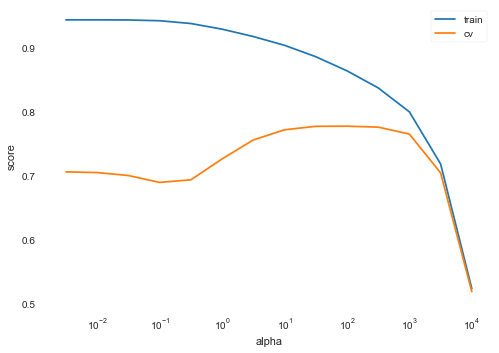

In [69]:
plt.semilogx(alphas, train_scores, label="train");
plt.semilogx(alphas, cv_scores, label="cv");
plt.legend();
plt.xlabel('alpha');
plt.ylabel('score');

In [70]:
best_alpha = alphas[np.argmax(cv_scores)]
best_alpha

100.0

- It seems `alpha=100` is the best choice here. 
- BTW, because it's so common to want to tune `alpha` with `Ridge`, sklearn provides a class called `RidgeCV`, which automatically tunes `alpha` based on cross-validation.

In [71]:
ridgecv = make_pipeline(preprocessing, RidgeCV(alphas=alphas))

In [72]:
ridgecv.fit(X_train, y_train);

In [73]:
ridgecv[1].alpha_

31.622776601683793

- Looks like it chose a slightly lower alpha.
- As we can see above they get very similar scores. 
- It's probably a matter of luck because they use a slightly different cv procedure in `RidgeCV`.
- Note: you can extract the CV values from `RidgeCV` but I'll not do that for consistency with other estimators.

<br><br><br><br>

## Error metrics revisited (15 min)

Let's check the performance of our model with `alpha=100`:

In [74]:
lr_tuned = make_pipeline(preprocessing, Ridge(alpha=best_alpha))
lr_tuned.fit(X_train, y_train);

In [75]:
lr_tuned.score(X_train, y_train)

0.8594431482602665

Looks reasonable. Let's check the MSE:

In [76]:
mean_squared_error(y_train, lr_tuned.predict(X_train))

899116998.3843598

- That looks huge. Is that $1 Billion??

<br><br><br><br>

- Answer: unlike classification, with regression our target has _units_.
- The target is in dollars, the mean **squared** error is in dollars^2. 
- A more relatable metric would be the **root** mean squared error, or RMSE

In [77]:
np.sqrt(mean_squared_error(y_train, lr_tuned.predict(X_train)))

29985.27969494965

- Ahh, so \$30,000. That makes more sense. 
- Can we dig deeper?
- There are some new diagnostics that didn't make sense with classification, e.g.:

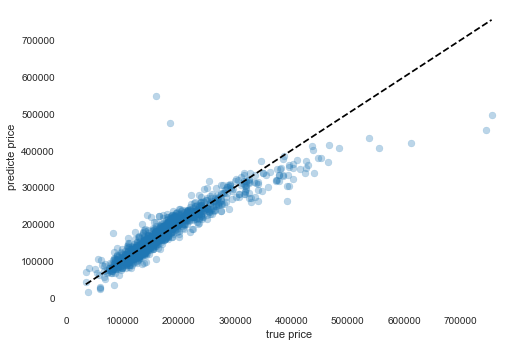

In [78]:
plt.scatter(y_train, lr_tuned.predict(X_train), alpha=0.3)
grid = np.linspace(y_train.min(), y_train.max(), 1000)
plt.plot(grid, grid, '--k');
plt.xlabel("true price");
plt.ylabel("predicte price");

- Here we can see a few cases where our prediction is way off.
  - (Is there something weird about those houses, perhaps? Stay tuned for a later lecture on outliers!)
- Under the line means we're under-prediction, over the line means we're over-predicting.
- Question: Is an error of \\$30,000 acceptable?

<br><br><br><br>

- For a house worth \\$600k, it seems reasonable! That's 5% error.
- For a house worth \\$60k, that is terrible. It's 50% error.

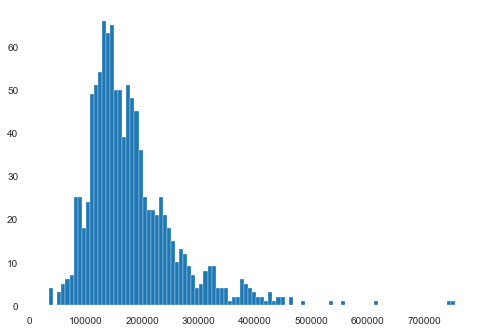

In [79]:
plt.hist(y_train, bins=100);

- Indeed, we have both of these cases in our dataset.
- Can we compute percent error?

In [80]:
pred_train = lr_tuned.predict(X_train)

In [81]:
percent_errors = (pred_train - y_train)/y_train * 100.
percent_errors

Id
1447   -11.766144
1124   -12.788780
187      8.833189
1021    -5.232417
68      -1.253030
          ...    
1042     3.912419
1123   -26.323548
1347    -9.448563
1407     1.497802
1390     1.457196
Name: SalePrice, Length: 1095, dtype: float64

- These are both positive (predict too high) and negative (predict too low).
- We can look at the absolute percent error:

In [82]:
np.abs(percent_errors)

Id
1447    11.766144
1124    12.788780
187      8.833189
1021     5.232417
68       1.253030
          ...    
1042     3.912419
1123    26.323548
1347     9.448563
1407     1.497802
1390     1.457196
Name: SalePrice, Length: 1095, dtype: float64

And, like MSE, we can take the average over examples. This is called **mean absolute percent error (MAPE)**.

In [83]:
def mape(true, pred):
    return 100.*np.mean(np.abs((pred - true)/true))

In [84]:
mape(y_train, pred_train)

10.270294102376743

In [85]:
mape(y_test, lr_tuned.predict(X_test))

9.902318580553876

- Ok, this is quite interpretable.
- On average, we have around 10% error. Good to know. 

## Transforming the targets (10 min)

- ... but wait a minute, does `.fit()` know we care about MAPE? 
- No, it doesn't. Why are we minimizing MSE (or something similar) if we care about MAPE??
- When minimizing MSE, **the expensive houses will dominate** because they have the biggest error.
- Which is better for RMSE?

Model A

- Example 1: Truth: \\$50k, Prediction: \\$100k
- Example 2: Truth: \\$500k, Prediction: \\$550k
- RMSE: $50k
- MAPE: 45%

Model B

- Example 1: Truth: \\$50k, Prediction: \\$60k
- Example 2: Truth: \\$500k, Prediction: \\$600k
- RMSE: $71k
- MAPE: 20%

In [86]:
np.sqrt((10**2+100**2)/2) # Model B RMSE

71.06335201775947

- How can we get `.fit()` to think about MAPE?
- Hacky approach that we'll take in this course: **log transform the targets**.
  - That is, transform $y\rightarrow \log(y)$.
- Why?
  - I have some mathematical intuition, which I removed because people found it confusing.
  - I did some experiments, it seems to work often.
  - Very high-level explanation: log turns addition/subtraction into multiplication/division, which is what we want (fractional error instead of absolute error).
- Let's look again at the distribution of our house prices:

Another argument for log-transforming:

- Linear regression can predict negative prices! 
- Log transforming avoids that.

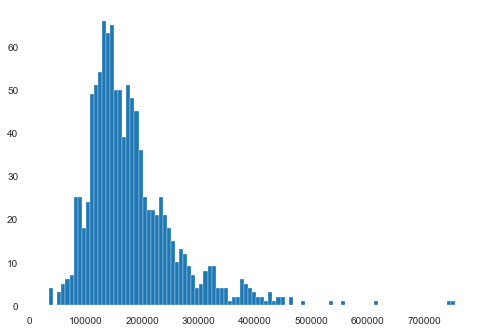

In [87]:
plt.hist(y_train, bins=100);

What happens if we log-transform?

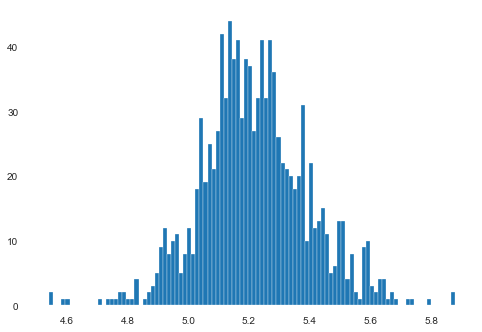

In [88]:
plt.hist(np.log10(y_train), bins=100);

- A stats class would tell you this is good for a different reason, regarding the assumptions built into linear regression.
- However, what I'm talking about here is more general, i.e. I would do this for random forest regression as well.
- Note: the base of the log doesn't matter, I'm just using `np.log` which is the natural log.

In [89]:
lr_tuned_log = make_pipeline(preprocessing, Ridge(alpha=best_alpha))
lr_tuned_log.fit(X_train, np.log(y_train));

Now, look at the predictions:

In [90]:
lr_tuned_log.predict(X_train)

array([11.80853357, 11.62932374, 12.13865765, ..., 12.39483118,
       11.79478723, 11.79104364])

These are log predictions. We can `exp` them to get back to dollars:

In [91]:
preds = np.exp(lr_tuned_log.predict(X_train))
preds

array([134394.33701677, 112344.32203582, 186961.43568285, ...,
       241549.85763165, 132559.54606319, 132064.22564498])

In [92]:
mape(y_train, lr_tuned.predict(X_train))

10.270294102376743

In [93]:
mape(y_train, np.exp(lr_tuned_log.predict(X_train)))

8.990404941661133

- BAM! We reduced the MAPE from 10% to 9% with this trick.

In [94]:
from sklearn.metrics import make_scorer

In [95]:
mape_scorer = make_scorer(mape, greater_is_better=False)

In [96]:
-cross_val_score(lr_tuned, X_train, y_train, scoring=mape_scorer).mean()

11.454138091416322

- What do you think happened to the MSE/R^2?

In [97]:
lr_tuned.score(X_train, y_train)

0.8594431482602665

In [98]:
r2_score(y_train, np.exp(lr_tuned_log.predict(X_train)))

0.8455046645654942

- The R^2 score (or MSE) got worse.
- This is typical because the default settings try to optimize this metric.
- In fact we saw something similar when setting `class_weight` with classification
  - The metric we cared about got better due to our changes
  - The default metric (accuracy in that case) got worse.


- Note that log-transforming assumes the $y$-values are positive, which is true in this case.
  - There is still a problem if one of the $y$-values (house prices) is zero, so it's common to do $\log(1+y)$ instead of $\log(y)$.
  - There is even a numpy function to do this for you: [`log1p`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log1p.html) and its inverse [`expm1`](https://numpy.org/doc/stable/reference/generated/numpy.expm1.html#numpy.expm1).

#### Making this easier with sklearn

Sklearn provides a more convenient way of keeping track of all the transforming and un-transforming:

In [99]:
from sklearn.compose import TransformedTargetRegressor

In [100]:
ttr = TransformedTargetRegressor(Ridge(alpha=best_alpha), func=np.log1p, inverse_func=np.expm1)
ttr_pipe = make_pipeline(preprocessing, ttr)

In [101]:
ttr_pipe.fit(X_train, y_train); # y_train automatically transformed

- This is the same as what we were doing before, just more convenient.
- As you'll see scores and predictions are the same:

In [102]:
ttr_pipe.predict(X_train) # predictions automatically un-transformed

array([134394.37643232, 112344.31728299, 186961.42047628, ...,
       241549.77174176, 132559.55478839, 132064.21274227])

In [103]:
np.exp(lr_tuned_log.predict(X_train))

array([134394.33701677, 112344.32203582, 186961.43568285, ...,
       241549.85763165, 132559.54606319, 132064.22564498])

In [104]:
mape(y_test, ttr_pipe.predict(X_test))

8.510124574626456

In [105]:
mape(y_test, np.exp(lr_tuned_log.predict(X_test)))

8.510126959179724

Note: when using `TransformedTargetRegressor` with `GridSearchCV` or `RandomizedSearchCV`, you would access a hyperparameter with something like `"transformedtargetregressor__regressor__alpha"`.

- With `TransformedTargetRegressor` we can now pass the pipeline into our cross-validation functions.
- Here we show that the MAPE did actually improve when we did the log-transforming.

In [106]:
-cross_val_score(ttr_pipe, X_train, y_train, scoring=mape_scorer, cv=20).mean()

10.682257392672264

In [107]:
-cross_val_score(lr_tuned, X_train, y_train, scoring=mape_scorer, cv=20).mean()

11.337788223346793

In [110]:
cross_validate_std(ttr_pipe, X_train, y_train, scoring=mape_scorer, cv=20, return_train_score=True)

fit_time            0.052251
score_time          0.012248
test_score        -10.682257
train_score        -8.969612
std_test_score      4.831888
std_train_score     0.197074
dtype: float64

In [109]:
cross_validate_std(lr_tuned, X_train, y_train, scoring=mape_scorer, cv=20, return_train_score=True)

fit_time            0.050480
score_time          0.012203
test_score        -11.337788
train_score       -10.271720
std_test_score      2.273924
std_train_score     0.166379
dtype: float64

- Note: you can ignore the negative signs. 
- Because MAPE is an error, where lower is better, it flips the sign to be negative so that higher is better.
- That way something like `GridSearchCV` will correctly rank the models (it looks for the highest score).

## Summary

- House prices dataset target is price, which is numeric -> regression rather than classification
- There are corresponding versions of all the tools we used:
  - `DummyClassifier` -> `DummyRegressor`
  - `LogisticRegression` -> `Ridge`
  - `RandomForestClassifier` -> `RandomForestRegressor`
  - `VotingClassifier` -> `VotingRegressor`
  - `XGBClassifier` -> `XGBRegressor`
  - etc.
- `Ridge` hyperparameter `alpha` like `LogisticRegression` hyperparameter `C`, but opposite meaning
- We'll avoid `LinearRegression` in this course
- Scoring metrics
  - $R^2$ is the default `.score()`, it is unitless, 0 is bad, 1 is best
  - MSE (mean squared error) is in units of target squared, hard to interpret; 0 is best
  - RMSE (root mean squared error) is in the same units as the target; 0 is best
  - MAPE (mean average percent error) is unitless; 0 is best, 1 is bad
- log-transforming the targets can improve the MAPE on the original targets
- `TransformedTargetRegressor` makes log-transforming more convenient and allows us to do use functions like `cross_validate` when transforming the targets.

<br><br>

## Linear regression True/False (Piazza)

1. sklearn's `LinearRegression` behaves erratically if we're not carefully; in this course, we won't use it.
2. With `Ridge`, larger values of `alpha` are probably more useful when I have lots of features.
3. log-transforming the targets (and re-fitting) is equivalent to log-transforming the coefficients. 
4. In regression, one should use MAPE instead of MSE when relative (percent) error matters more than absolute error.